In [ ]:
import tensorflow as tf
from keras.initializers import RandomNormal

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Model

In [ ]:
def define_encoder_block(layer_inp, n_filters, batch_norm=True):
    init = RandomNormal(mean=0, stddev=0.02) # kernel weights initialization

    x = Conv2D(filters=n_filters,
               kernel_size=(4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(layer_inp)
    
    if batch_norm:
        x = BatchNormalization()(x, training=True)

    x = LeakyReLU(alpha=0.2)(x)

    return x   

In [ ]:
def define_decoder_block(layer_inp, n_filters, skip_inp, dropout=False):
    init = RandomNormal(mean=0, stddev=0.02) # kernel weights initialization

    x = Conv2DTranspose(filters=n_filters,
                        kernel_size=(4, 4),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(layer_inp)
    
    x = BatchNormalization()(x, training=True)

    if dropout:
        x = Dropout(0.5)(x, training=True)
    
    x = Concatenate()([x, skip_inp])
    
    x = relu(x)
	
    return x

In [ ]:
def define_encoder(inputs):
    e1 = define_encoder_block(inputs, n_filters=64, batch_norm=False)
    e2 = define_encoder_block(e1, n_filters=128)
    e3 = define_encoder_block(e2, n_filters=256)
    e4 = define_encoder_block(e3, n_filters=512)
    e5 = define_encoder_block(e4, n_filters=512)
    e6 = define_encoder_block(e5, n_filters=512)
    e7 = define_encoder_block(e6, n_filters=512)

    return (e1, e2, e3, e4, e5, e6), e7

In [ ]:
def define_bottleneck(inputs, n_filter):
    init = RandomNormal(mean=0, stddev=0.02) # kernel weights initialization

    x = Conv2D(filters=n_filter,
               kernel_size=(4, 4),
               strides=(2, 2),
               padding='same',
               kernel_initializer=init)(inputs)
    
    x = relu(x)
    
    return x

In [ ]:
def define_decoder(inputs, convs):
    e1, e2, e3, e4, e5, e6, e7 = convs

    d6 = define_decoder_block(inputs, n_filters=512, skip_inp=e7, dropout=True) # Check
    d5 = define_decoder_block(d6, n_filters=512, skip_inp=e6, dropout=True)
    d4 = define_decoder_block(d5, n_filters=512, skip_inp=e5, dropout=True)
    d3 = define_decoder_block(d4, n_filters=512, skip_inp=e4)
    d2 = define_decoder_block(d3, n_filters=256, skip_inp=e3)
    d1 = define_decoder_block(d2, n_filters=128, skip_inp=e2)
    dec_output = define_decoder_block(d1, n_filters=64, skip_inp=e1)
    
    return dec_output

In [ ]:
def define_generator(inp_shape=(256, 256, 3)): # check shape ?
    init = RandomNormal(mean=0, stddev=0.02) # kernel weights initialization

    inputs = Input(shape=inp_shape)

    (e1, e2, e3, e4, e5, e6), e7 = define_encoder(inputs)
    b = define_bottleneck(e7, n_filter=512)
    dec_output = define_decoder(b, convs=(e1, e2, e3, e4, e5, e6, e7))
    
    x = Conv2DTranspose(filters=inp_shape[2],
                        kernel_size=(4,4),
                        strides=(2,2), 
                        padding='same', 
                        kernel_initializer=init)(dec_output)
                        
    out_image = tanh(x)

    return Model(inputs=inputs, outputs=out_image)

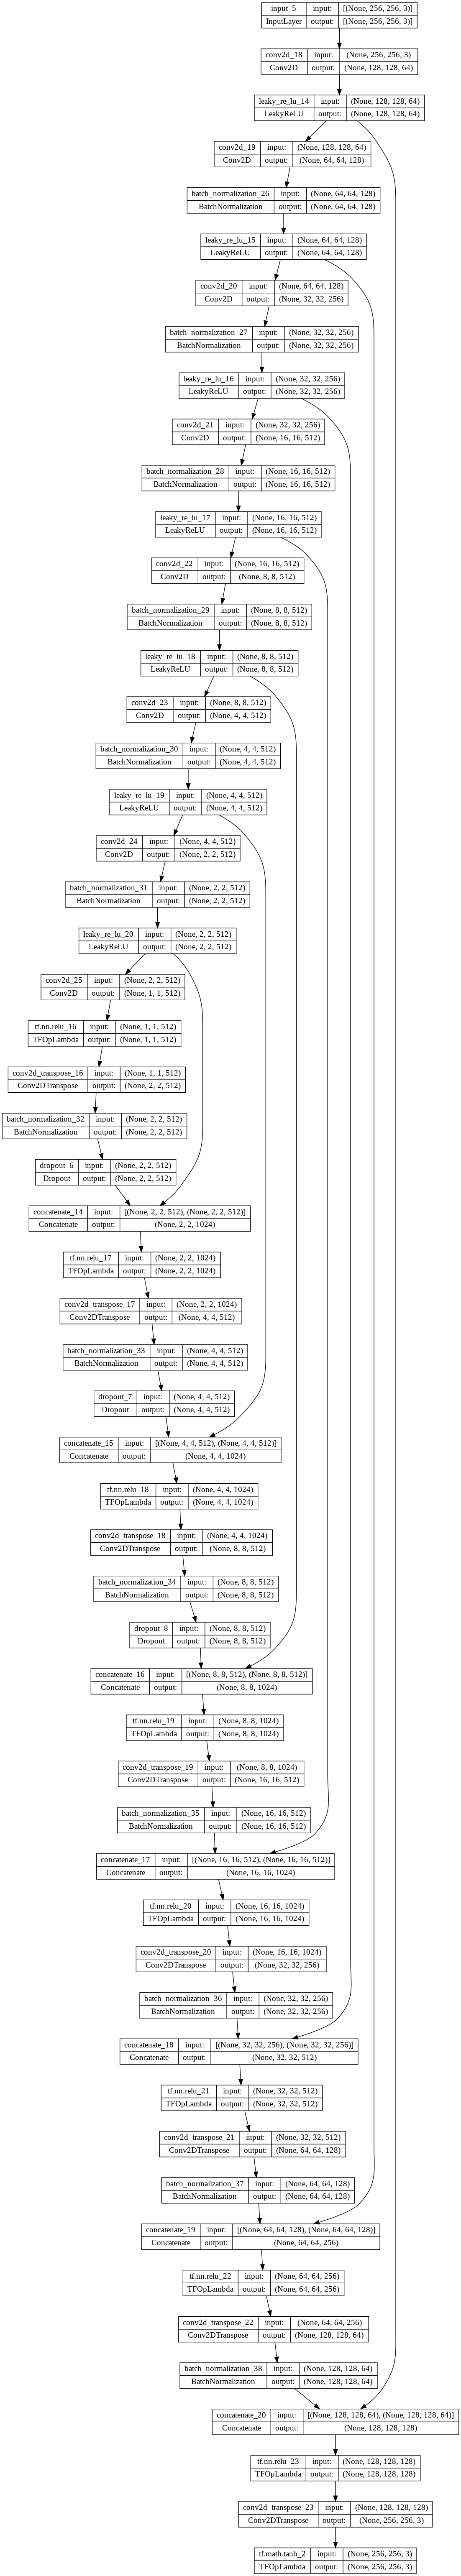

In [ ]:
# Get the generator model
generator = define_generator(inp_shape=(256,256,3))  # shape ?? check change from (600, 1200, 3)

# Compile the generator model
generator.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999))

# Plot the generator model
tf.keras.utils.plot_model(generator, show_shapes=True)